In [5]:
import xarray as xr

In [6]:
with xr.open_dataset("../../test_data/CPEXAW-DROPSONDE_D20210806_193025_PQC.nc", decode_cf=False) as ds:
        print(ds.data_vars)
        print("----------")
        for key in ds.attrs:
                print(key)

Data variables:
    trajectory      |S1 ...
    launch_time     int32 ...
    pres            (time) float32 ...
    tdry            (time) float32 ...
    dp              (time) float32 ...
    rh              (time) float32 ...
    u_wind          (time) float32 ...
    v_wind          (time) float32 ...
    w_wind          (time) float32 ...
    wspd            (time) float32 ...
    wdir            (time) float32 ...
    dz              (time) float32 ...
    mr              (time) float32 ...
    vt              (time) float32 ...
    theta           (time) float32 ...
    theta_e         (time) float32 ...
    theta_v         (time) float32 ...
    lat             (time) float32 ...
    lon             (time) float32 ...
    alt             (time) float32 ...
    gpsalt          (time) float32 ...
    reference_time  (obs) int32 ...
    reference_pres  (obs) float32 ...
    reference_tdry  (obs) float32 ...
    reference_rh    (obs) float32 ...
    reference_wspd  (obs) float32 .

In [7]:
with xr.open_dataset("../../test_data/CPEXAW-DROPSONDE_D20210820_203208_PQC.nc", decode_cf=False) as ds:
        rh = ds['rh'].values # relative humidity
        dp = ds['dp'].values # dew point
        tdry = ds['tdry'].values # temp dry???
        lat = ds['lat'].values
        lon = ds['lon'].values
        alt = ds['alt'].values
        time = ds['time'].values

        print(len(rh), "-", (rh.shape)) #np ndarray
        print(len(dp), "-", (dp.shape)) 
        print(len(tdry), "-", (tdry.shape)) 
        print(len(lat), "-", (lat.shape))
        print(len(lon), "-", (lon.shape))
        print(len(alt), "-", (alt.shape))   
        print(len(time), "-", (time.shape)) 

        # print(time, len(time)) 
        print(lat[123])
        print(lon[123])
        print(alt[123])   


2979 - (2979,)
2979 - (2979,)
2979 - (2979,)
2979 - (2979,)
2979 - (2979,)
2979 - (2979,)
2979 - (2979,)
-999.0
-999.0
-999.0


netcdf to zarr

In [8]:
import numpy as np
import xarray as xr

def main():
    """
    Converts Level 1B crs data from s3 to zarr file and then stores it in the provided folder
    Args:
        folder (string): name to hold the raw files.
        file (string): the s3 url to the raw file.
    """

    # open dataset.
    with xr.open_dataset("../../test_data/CPEXAW-DROPSONDE_D20210820_203208_PQC.nc", decode_cf=False) as ds:
        rh = ds['rh'].values # relative humidity
        dp = ds['dp'].values # dew point
        tdry = ds['tdry'].values # temp dry???
        lat = ds['lat'].values
        lon = ds['lon'].values
        alt = ds['alt'].values
        time = ds['time'].values

    # data formation
    
    # sort data by time
    sort_idx = np.argsort(time)

    lon = lon[sort_idx]
    lat = lat[sort_idx]
    alt = alt[sort_idx]
    time = time[sort_idx]
    rh = rh[sort_idx]
    dp = dp[sort_idx]
    tdry = tdry[sort_idx]

    # remove nan and infinite using mask ???
    mask = np.logical_and(alt != -999.0, lon != -999.0, lat != -999.0)
    # mask = np.logical_and(np.isfinite(ref), alt > 0, alt != -999.0, lon != -999.0, lat != -999.0)
    lon = lon[mask]
    lat = lat[mask]
    alt = alt[mask]
    time = time[mask]
    rh = rh[mask]
    dp = dp[mask]
    tdry = tdry[mask]

    # remove nan and infinite using mask ???
    mask = np.logical_and(rh > -100, rh > -100)
    # mask = np.logical_and(np.isfinite(ref), alt > 0, alt != -999.0, lon != -999.0, lat != -999.0)
    lon = lon[mask]
    lat = lat[mask]
    alt = alt[mask]
    time = time[mask]
    rh = rh[mask]
    dp = dp[mask]
    tdry = tdry[mask]

    return (lon, lat, alt, time, rh, dp, tdry)    

In [9]:
(lon, lat, alt, time, rh, dp, tdry) = main()

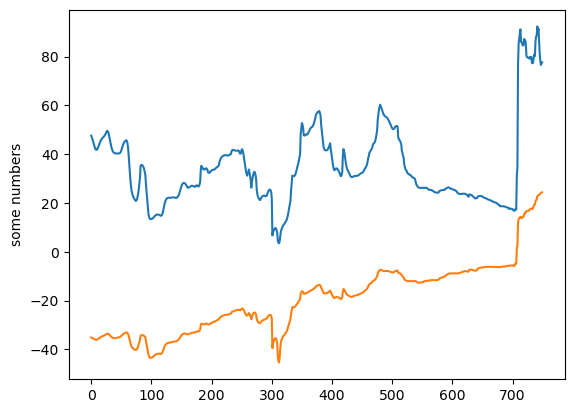

In [10]:
import matplotlib.pyplot as plt
# plt.plot(lon)
# plt.plot(lat)

# plt.ylim([0, np.max(alt)/100])

plt.plot(rh)
plt.plot(dp)
# plt.plot(tdry)

plt.ylabel('some numbers')
# plt.xaxis['autorange'] = "reversed"

plt.show()

In [11]:
# rotate the plot

In [12]:
np.max(alt)

8984.2

In [13]:
# import pandas as pd
# import numpy as np
# import plotly.express as px

# df = pd.DataFrame(
#     {"var1": np.random.uniform(1, 5, 30), "var2": np.random.uniform(4, 10, 30)}
# )

# fig = px.scatter(df, x="var1", y="var2")

# fig.update_layout(
#     updatemenus=[
#         {
#             "buttons": [
#                 {
#                     "label": combi,
#                     "method": "restyle",
#                     "args": [
#                         {"x": [fig.data[0][combi[0]]], "y": [fig.data[0][combi[1]]]}
#                     ],
#                 }
#                 for combi in ["xy", "yx"]
#             ]
#         }
#     ]
# )

In [14]:
import plotly.graph_objects as go
go.Figure(data=go.Scatter(x=rh, y=dp))

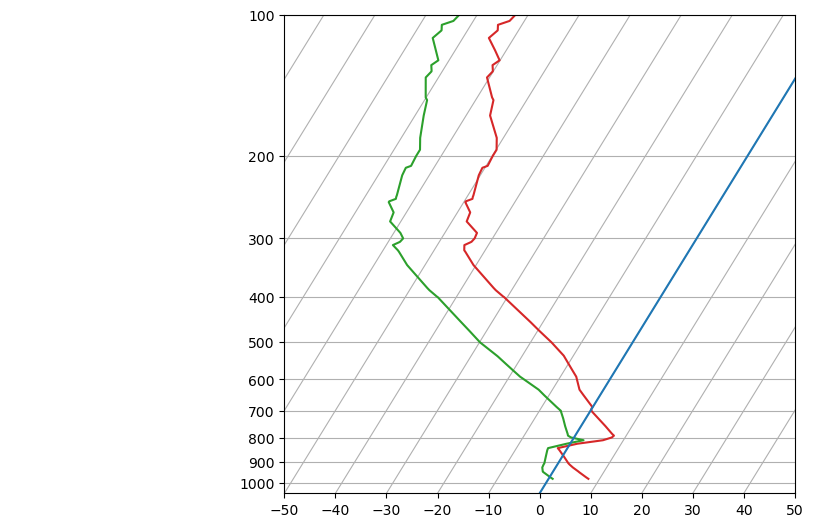

In [15]:
from contextlib import ExitStack

from matplotlib.axes import Axes
import matplotlib.transforms as transforms
import matplotlib.axis as maxis
import matplotlib.spines as mspines
from matplotlib.projections import register_projection


# The sole purpose of this class is to look at the upper, lower, or total
# interval as appropriate and see what parts of the tick to draw, if any.
class SkewXTick(maxis.XTick):
    def draw(self, renderer):
        # When adding the callbacks with `stack.callback`, we fetch the current
        # visibility state of the artist with `get_visible`; the ExitStack will
        # restore these states (`set_visible`) at the end of the block (after
        # the draw).
        with ExitStack() as stack:
            for artist in [self.gridline, self.tick1line, self.tick2line,
                           self.label1, self.label2]:
                stack.callback(artist.set_visible, artist.get_visible())
            needs_lower = transforms.interval_contains(
                self.axes.lower_xlim, self.get_loc())
            needs_upper = transforms.interval_contains(
                self.axes.upper_xlim, self.get_loc())
            self.tick1line.set_visible(
                self.tick1line.get_visible() and needs_lower)
            self.label1.set_visible(
                self.label1.get_visible() and needs_lower)
            self.tick2line.set_visible(
                self.tick2line.get_visible() and needs_upper)
            self.label2.set_visible(
                self.label2.get_visible() and needs_upper)
            super().draw(renderer)

    def get_view_interval(self):
        return self.axes.xaxis.get_view_interval()


# This class exists to provide two separate sets of intervals to the tick,
# as well as create instances of the custom tick
class SkewXAxis(maxis.XAxis):
    def _get_tick(self, major):
        return SkewXTick(self.axes, None, major=major)

    def get_view_interval(self):
        return self.axes.upper_xlim[0], self.axes.lower_xlim[1]


# This class exists to calculate the separate data range of the
# upper X-axis and draw the spine there. It also provides this range
# to the X-axis artist for ticking and gridlines
class SkewSpine(mspines.Spine):
    def _adjust_location(self):
        pts = self._path.vertices
        if self.spine_type == 'top':
            pts[:, 0] = self.axes.upper_xlim
        else:
            pts[:, 0] = self.axes.lower_xlim


# This class handles registration of the skew-xaxes as a projection as well
# as setting up the appropriate transformations. It also overrides standard
# spines and axes instances as appropriate.
class SkewXAxes(Axes):
    # The projection must specify a name.  This will be used be the
    # user to select the projection, i.e. ``subplot(projection='skewx')``.
    name = 'skewx'

    def _init_axis(self):
        # Taken from Axes and modified to use our modified X-axis
        self.xaxis = SkewXAxis(self)
        self.spines.top.register_axis(self.xaxis)
        self.spines.bottom.register_axis(self.xaxis)
        self.yaxis = maxis.YAxis(self)
        self.spines.left.register_axis(self.yaxis)
        self.spines.right.register_axis(self.yaxis)

    def _gen_axes_spines(self):
        spines = {'top': SkewSpine.linear_spine(self, 'top'),
                  'bottom': mspines.Spine.linear_spine(self, 'bottom'),
                  'left': mspines.Spine.linear_spine(self, 'left'),
                  'right': mspines.Spine.linear_spine(self, 'right')}
        return spines

    def _set_lim_and_transforms(self):
        """
        This is called once when the plot is created to set up all the
        transforms for the data, text and grids.
        """
        rot = 30

        # Get the standard transform setup from the Axes base class
        super()._set_lim_and_transforms()

        # Need to put the skew in the middle, after the scale and limits,
        # but before the transAxes. This way, the skew is done in Axes
        # coordinates thus performing the transform around the proper origin
        # We keep the pre-transAxes transform around for other users, like the
        # spines for finding bounds
        self.transDataToAxes = (
            self.transScale
            + self.transLimits
            + transforms.Affine2D().skew_deg(rot, 0)
        )
        # Create the full transform from Data to Pixels
        self.transData = self.transDataToAxes + self.transAxes

        # Blended transforms like this need to have the skewing applied using
        # both axes, in axes coords like before.
        self._xaxis_transform = (
            transforms.blended_transform_factory(
                self.transScale + self.transLimits,
                transforms.IdentityTransform())
            + transforms.Affine2D().skew_deg(rot, 0)
            + self.transAxes
        )

    @property
    def lower_xlim(self):
        return self.axes.viewLim.intervalx

    @property
    def upper_xlim(self):
        pts = [[0., 1.], [1., 1.]]
        return self.transDataToAxes.inverted().transform(pts)[:, 0]


# Now register the projection with matplotlib so the user can select it.
register_projection(SkewXAxes)

if __name__ == '__main__':
    # Now make a simple example using the custom projection.
    from io import StringIO
    from matplotlib.ticker import (MultipleLocator, NullFormatter,
                                   ScalarFormatter)
    import matplotlib.pyplot as plt
    import numpy as np

    # Some example data.
    data_txt = '''
        978.0    345    7.8    0.8
        971.0    404    7.2    0.2
        946.7    610    5.2   -1.8
        944.0    634    5.0   -2.0
        925.0    798    3.4   -2.6
        911.8    914    2.4   -2.7
        906.0    966    2.0   -2.7
        877.9   1219    0.4   -3.2
        850.0   1478   -1.3   -3.7
        841.0   1563   -1.9   -3.8
        823.0   1736    1.4   -0.7
        813.6   1829    4.5    1.2
        809.0   1875    6.0    2.2
        798.0   1988    7.4   -0.6
        791.0   2061    7.6   -1.4
        783.9   2134    7.0   -1.7
        755.1   2438    4.8   -3.1
        727.3   2743    2.5   -4.4
        700.5   3048    0.2   -5.8
        700.0   3054    0.2   -5.8
        698.0   3077    0.0   -6.0
        687.0   3204   -0.1   -7.1
        648.9   3658   -3.2  -10.9
        631.0   3881   -4.7  -12.7
        600.7   4267   -6.4  -16.7
        592.0   4381   -6.9  -17.9
        577.6   4572   -8.1  -19.6
        555.3   4877  -10.0  -22.3
        536.0   5151  -11.7  -24.7
        533.8   5182  -11.9  -25.0
        500.0   5680  -15.9  -29.9
        472.3   6096  -19.7  -33.4
        453.0   6401  -22.4  -36.0
        400.0   7310  -30.7  -43.7
        399.7   7315  -30.8  -43.8
        387.0   7543  -33.1  -46.1
        382.7   7620  -33.8  -46.8
        342.0   8398  -40.5  -53.5
        320.4   8839  -43.7  -56.7
        318.0   8890  -44.1  -57.1
        310.0   9060  -44.7  -58.7
        306.1   9144  -43.9  -57.9
        305.0   9169  -43.7  -57.7
        300.0   9280  -43.5  -57.5
        292.0   9462  -43.7  -58.7
        276.0   9838  -47.1  -62.1
        264.0  10132  -47.5  -62.5
        251.0  10464  -49.7  -64.7
        250.0  10490  -49.7  -64.7
        247.0  10569  -48.7  -63.7
        244.0  10649  -48.9  -63.9
        243.3  10668  -48.9  -63.9
        220.0  11327  -50.3  -65.3
        212.0  11569  -50.5  -65.5
        210.0  11631  -49.7  -64.7
        200.0  11950  -49.9  -64.9
        194.0  12149  -49.9  -64.9
        183.0  12529  -51.3  -66.3
        164.0  13233  -55.3  -68.3
        152.0  13716  -56.5  -69.5
        150.0  13800  -57.1  -70.1
        136.0  14414  -60.5  -72.5
        132.0  14600  -60.1  -72.1
        131.4  14630  -60.2  -72.2
        128.0  14792  -60.9  -72.9
        125.0  14939  -60.1  -72.1
        119.0  15240  -62.2  -73.8
        112.0  15616  -64.9  -75.9
        108.0  15838  -64.1  -75.1
        107.8  15850  -64.1  -75.1
        105.0  16010  -64.7  -75.7
        103.0  16128  -62.9  -73.9
        100.0  16310  -62.5  -73.5
    '''

    # Parse the data
    sound_data = StringIO(data_txt)
    p, h, T, Td = np.loadtxt(sound_data, unpack=True)

    # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(6.5875, 6.2125))
    ax = fig.add_subplot(projection='skewx')

    plt.grid(True)

    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    ax.semilogy(T, p, color='C3')
    ax.semilogy(Td, p, color='C2')

    # An example of a slanted line at constant X
    l = ax.axvline(0, color='C0')

    # Disables the log-formatting that comes with semilogy
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.set_yticks(np.linspace(100, 1000, 10))
    ax.set_ylim(1050, 100)

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.set_xlim(-50, 50)

    plt.show()